# Rate Equation
## Objective
1. Define equation
2. Solve equation
3. Compute model and signal

```{note}
In this example, we only deal with gaussian and cauchy irf with same fwhm
```

In [2]:
# import needed module
import numpy as np
import matplotlib.pyplot as plt
import TRXASprefitpack
from TRXASprefitpack import solve_model, compute_model, rate_eq_conv 
plt.rcParams["figure.figsize"] = (14,10)

## Version information

In [3]:
print(TRXASprefitpack.__version__)

0.5.0


## basic information of functions

In [4]:
help(solve_model)

Help on function solve_model in module TRXASprefitpack.mathfun.rate_eq:

solve_model(equation: numpy.ndarray, y0: numpy.ndarray) -> Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]
    Solve system of first order rate equation
    
    Args:
      equation: matrix corresponding to model
      y0: initial condition
    
    Returns:
       1. eigenvalues of equation
       2. eigenvectors for equation
       3. coefficient where y0 = Vc



In [5]:
help(compute_model)

Help on function compute_model in module TRXASprefitpack.mathfun.rate_eq:

compute_model(t: numpy.ndarray, eigval: numpy.ndarray, V: numpy.ndarray, c: numpy.ndarray) -> numpy.ndarray
    Compute solution of the system of rate equations solved by solve_model
    Note: eigval, V, c should be obtained from solve_model
    
    Args:
     t: time
     eigval: eigenvalue for equation
     V: eigenvectors for equation
     c: coefficient
    
    Returns:
      solution of rate equation
    
    Note:
      eigval, V, c should be obtained from solve_model.



In [6]:
help(rate_eq_conv)

Help on function rate_eq_conv in module TRXASprefitpack.mathfun.exp_decay_fit:

rate_eq_conv(t: numpy.ndarray, fwhm: Union[float, numpy.ndarray], abs: numpy.ndarray, eigval: numpy.ndarray, V: numpy.ndarray, c: numpy.ndarray, irf: Union[str, NoneType] = 'g', eta: Union[float, NoneType] = None) -> numpy.ndarray
    Constructs signal model rate equation with
    instrumental response function
    Supported instrumental response function are
    
    irf
      * g: gaussian distribution
      * c: cauchy distribution
      * pv: pseudo voigt profile
    
    Args:
       t: time
       fwhm: full width at half maximum of instrumental response function
       abs: coefficient for each excited state
       eigval: eigenvalue of rate equation matrix 
       V: eigenvector of rate equation matrix 
       c: coefficient to match initial condition of rate equation
       irf: shape of instrumental
            response function [default: g]
    
              * 'g': normalized gaussian distributi

## Define equation

```{note}
In pump-probe time resolved spectroscopy, 
the concentration of ground state is not much important.
Only, the concentration of excited species are matter.
```

Consider model
```{code-block} python
'''
    k1     k2
A  ---> B ---> GS
y1: A
y2: B
y3: GS
'''
```

with initial condition 
\begin{equation*}
y(t) = \begin{cases}
(0, 0, 1) & \text{if $t < 0$}, \\
(1, 0, 0) & \text{if $t=0$}.
\end{cases}
\end{equation*}

Then what we need to solve is

\begin{equation*}
y'(t) = \begin{cases}
(0, 0, 0) & \text{if $t < 0$}, \\
Ay(t) & \text{if $t \geq 0$}
\end{cases}
\end{equation*}

with $y(0)=y_0$.

Where $A$ is

\begin{equation*}
A = \begin{pmatrix}
-k_1 & 0 & 0 \\
k_1 & -k_2 & 0 \\
0 & k_2 & 0
\end{pmatrix}
\end{equation*}


In [7]:
# set lifetime tau1 = 50 ps, tau2 = 1 ns
# set fwhm of IRF = 10 ps

tau1 = 50
tau2 = 1000
fwhm = 10

# initial condition
y0 = np.array([1, 0, 0])

# set time range
t_short = np.arange(-100,200,0.1)
t_long = np.arange(-2000,5000,10)

# Define equation
equation = np.array([[-1/tau1, 0, 0],
                    [1/tau1, -1/tau2, 0],
                    [0, 1/tau2, 0]])

# Solve equation
eigval, V, c = solve_model(equation, y0)

In [8]:
# Now compute model
y_short = compute_model(t_short, eigval, V, c)
y_long = compute_model(t_long, eigval, V, c)


# since, y_1 + y_2 + y_3 = 1 for all t,
# y3 = 1 - (y_1+y_2)

y_short[-1, :] = 1 - (y_short[0, :] + y_short[1, :])
y_long[-1, :] = 1 - (y_long[0, :] + y_long[1, :])

## plot model
1. short range

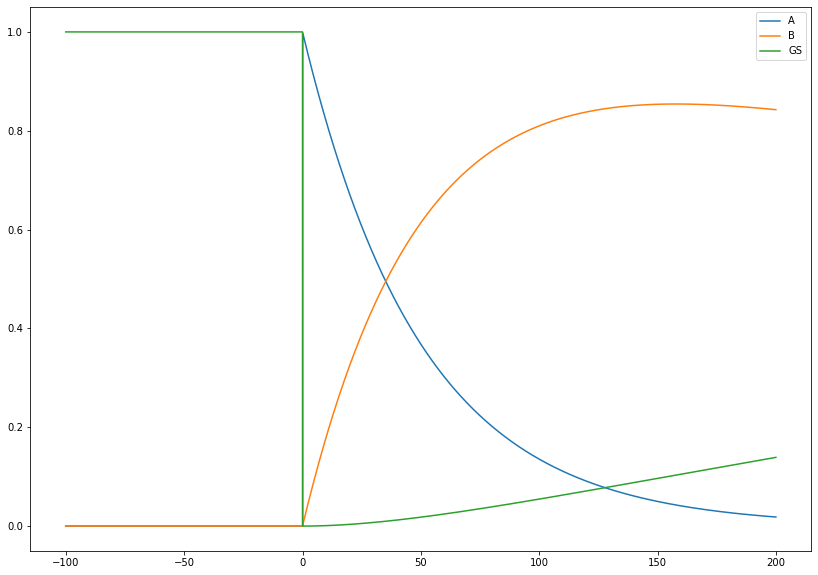

In [9]:
plt.plot(t_short, y_short[0, :], label='A')
plt.plot(t_short, y_short[1, :], label='B')
plt.plot(t_short, y_short[2, :], label='GS')
plt.legend()
plt.show()

2. long range

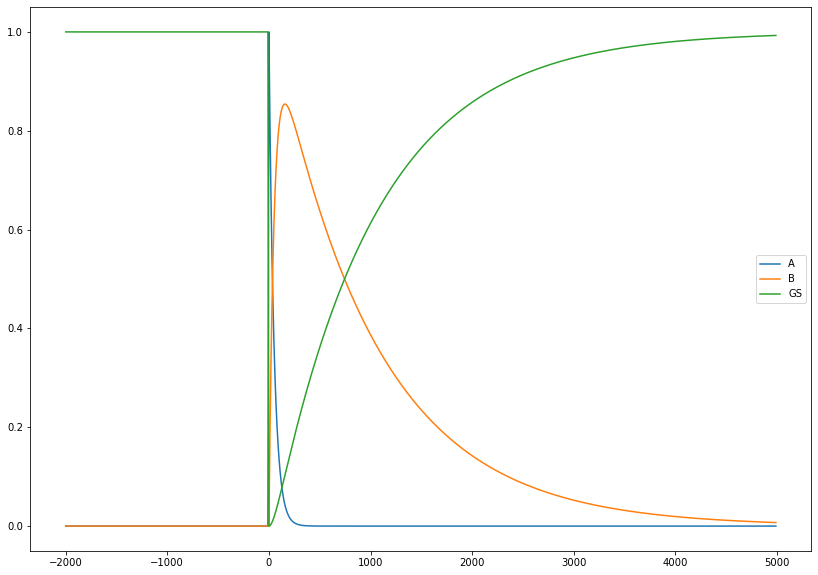

In [10]:
plt.plot(t_long, y_long[0, :], label='A')
plt.plot(t_long, y_long[1, :], label='B')
plt.plot(t_long, y_long[2, :], label='GS')
plt.legend()
plt.show()

## Compute Signal 
Difference absorption coefficient of ground state is 0
Now assume the difference absorption coefficient of A state is -0.5 and B state is 1

In [11]:
diff_abs = [-0.5, # A state
            1, # B state
            0, # ground state
           ]
y_short_gau = rate_eq_conv(t_short, fwhm, diff_abs, eigval, V, c, irf = 'g')
y_long_gau = rate_eq_conv(t_long, fwhm, diff_abs, eigval, V, c, irf = 'g')
y_short_cauchy = rate_eq_conv(t_short, fwhm, diff_abs, eigval, V, c, irf = 'c')
y_long_cauchy = rate_eq_conv(t_long, fwhm, diff_abs, eigval, V, c, irf = 'c')

## Plot signal
1. short range

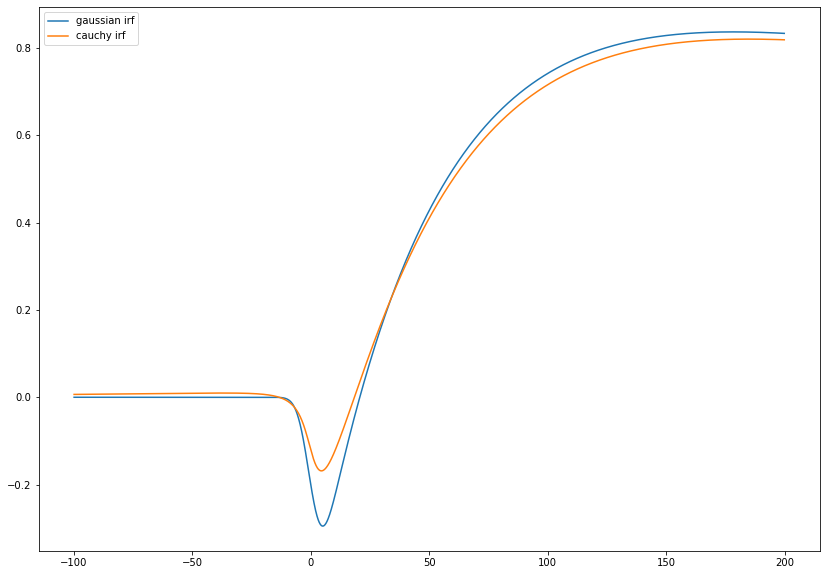

In [12]:
plt.plot(t_short, y_short_gau, label='gaussian irf')
plt.plot(t_short, y_short_cauchy, label='cauchy irf')
plt.legend()
plt.show()


2. long range

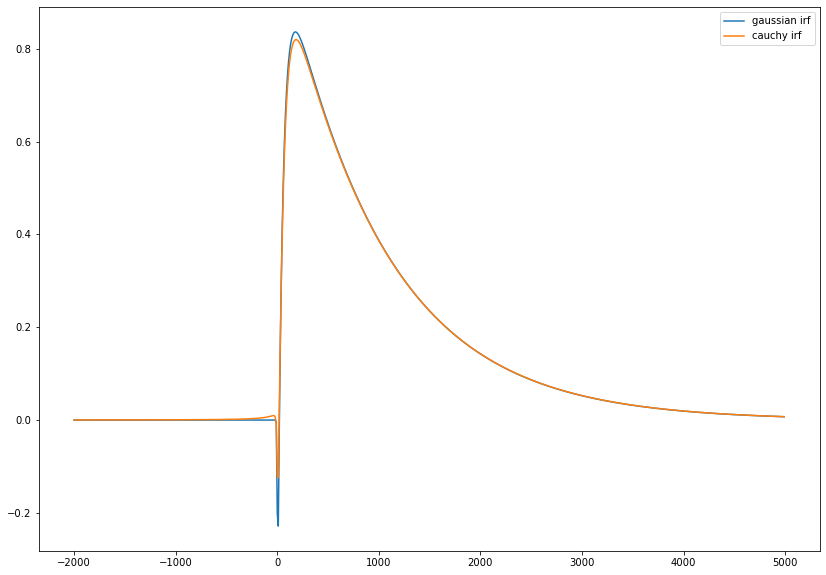

In [13]:
plt.plot(t_long, y_long_gau, label='gaussian irf')
plt.plot(t_long, y_long_cauchy, label='cauchy irf')
plt.legend()
plt.show()

## Compute Signal -2-
Difference absorption coefficient of ground state is 0
Now assume the difference absorption coefficient of A state is 0.5 and B state is 1

In [14]:
diff_abs = [0.5, # A state
            1, # B state
            0, # ground state
           ]
y_short_gau = rate_eq_conv(t_short, fwhm, diff_abs, eigval, V, c, irf = 'g')
y_long_gau = rate_eq_conv(t_long, fwhm, diff_abs, eigval, V, c, irf = 'g')
y_short_cauchy = rate_eq_conv(t_short, fwhm, diff_abs, eigval, V, c, irf = 'c')
y_long_cauchy = rate_eq_conv(t_long, fwhm, diff_abs, eigval, V, c, irf = 'c')

## Plot signal -2-
1. short range

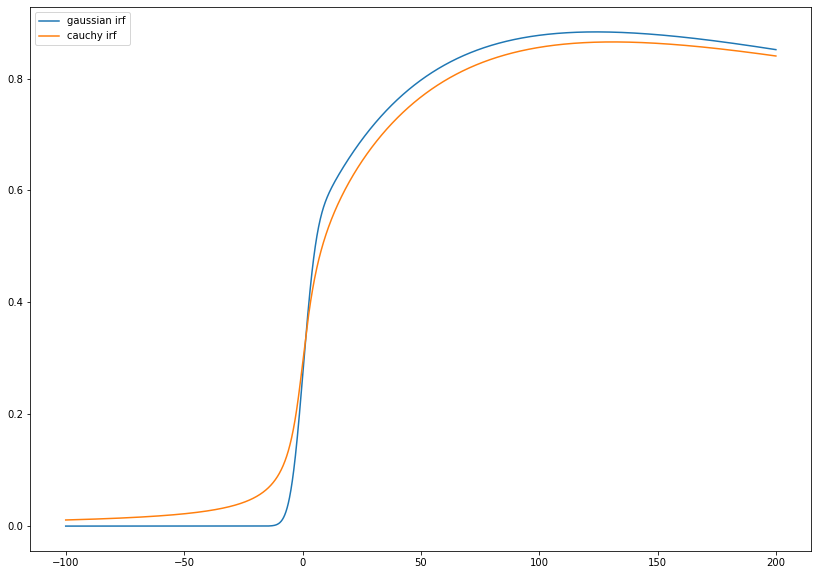

In [15]:
plt.plot(t_short, y_short_gau, label='gaussian irf')
plt.plot(t_short, y_short_cauchy, label='cauchy irf')
plt.legend()
plt.show()

2. long range

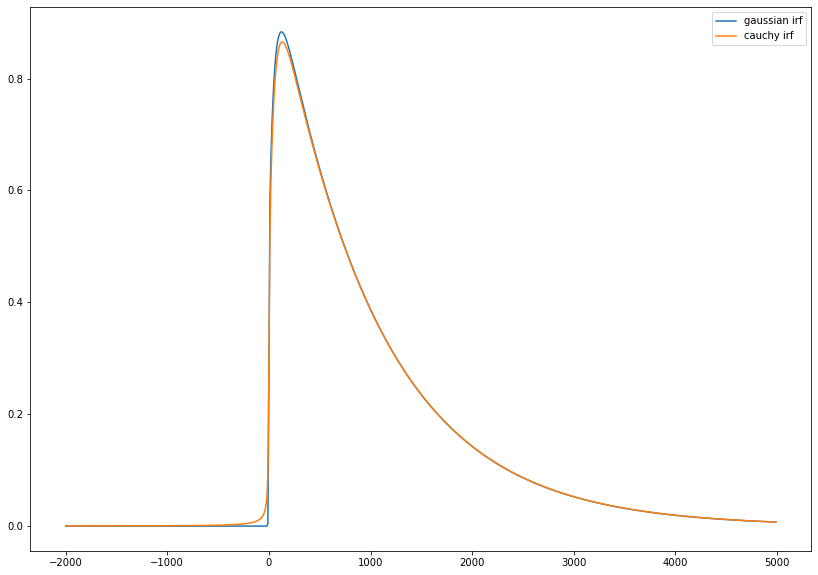

In [16]:
plt.plot(t_long, y_long_gau, label='gaussian irf')
plt.plot(t_long, y_long_cauchy, label='cauchy irf')
plt.legend()
plt.show()

## Compute Signal -3-
Difference absorption coefficient of ground state is 0
Now assume the difference absorption coefficient of A state is 1 and B state is 0.5

In [17]:
diff_abs = [1, # A state
            0.5, # B state
            0, # ground state
           ]
y_short_gau = rate_eq_conv(t_short, fwhm, diff_abs, eigval, V, c, irf = 'g')
y_long_gau = rate_eq_conv(t_long, fwhm, diff_abs, eigval, V, c, irf = 'g')
y_short_cauchy = rate_eq_conv(t_short, fwhm, diff_abs, eigval, V, c, irf = 'c')
y_long_cauchy = rate_eq_conv(t_long, fwhm, diff_abs, eigval, V, c, irf = 'c')

## Plot signal -3-
1. short range

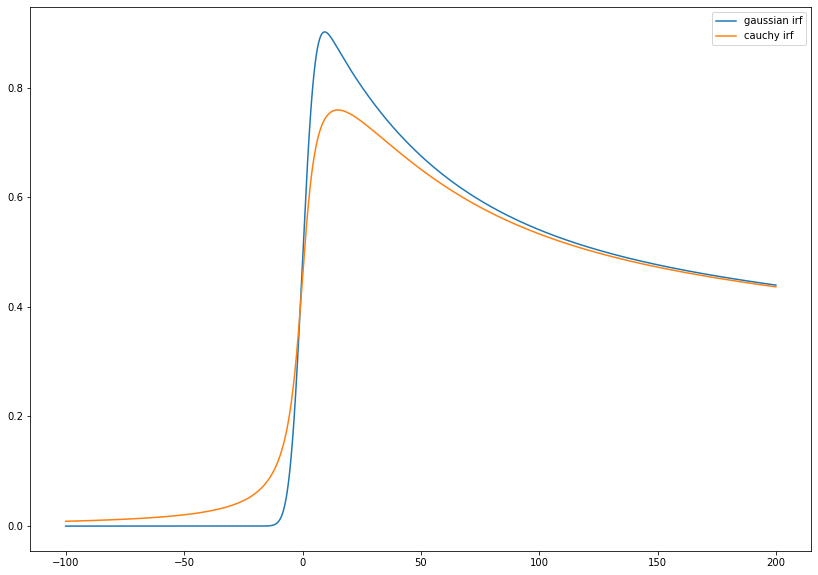

In [18]:
plt.plot(t_short, y_short_gau, label='gaussian irf')
plt.plot(t_short, y_short_cauchy, label='cauchy irf')
plt.legend()
plt.show()

2. long range

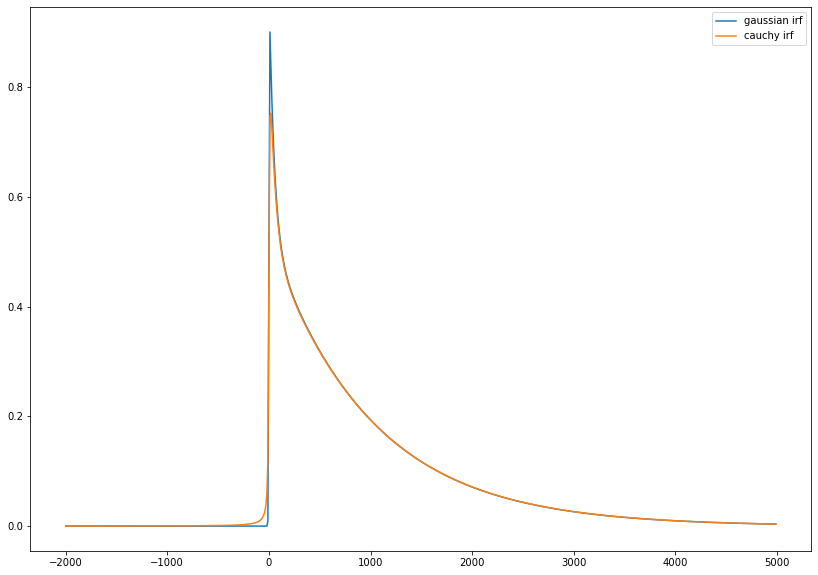

In [19]:
plt.plot(t_long, y_long_gau, label='gaussian irf')
plt.plot(t_long, y_long_cauchy, label='cauchy irf')
plt.legend()
plt.show()

## Conclusion
1. IRF broads the signal
2. At short range, gaussian signal is much sharper than cauchy signal.
3. At long range, gaussian signal and cauchy signal look similar.
4. If sign of difference abs of short lifetime state (A) and long lifetime state (B) is different, we can easy to see short lived state feature in the time trace spectrum.
5. If sign of two state is same and intensity of long lifetime state (B) is larger than that of short lifetime state (A), we hard to observe short lived state feature.
6. If sign of two state is same but intensity of short lifetime state (A) is larger than that of long lifetime state (B), we can see short lived state feature.